In [1]:
!python setup.py build_ext --inplace

running build_ext
running build_ext


In [2]:
import network_simulation as net_sims
import popconstruct as pops
import plotting_helper_functions as plt_help
import pandas as pd
import os
import time
import pdb

import pylab as pl
import pickle
import numpy as np
import pandas as pd
import pingouin
import sklearn 

def saveresults_vars(variable, prefix):
    pickle.dump(variable, open(prefix, 'wb'))
    
def loadresults_vars(prefix):
    return pickle.load(open(prefix, "rb"))

data_dir = "./Data/stop-params_freeze-analysis/"
figure_dir = "./Figures/stop-params_freeze-analysis/"

2023-08-18 12:26:25,423	INFO worker.py:1352 -- Connecting to existing Ray cluster at address: 127.0.0.1:6379...
2023-08-18 12:26:25,431	INFO worker.py:1529 -- Connected to Ray cluster. View the dashboard at http://127.0.0.1:8265 


In [3]:
solutions_onset = np.arange(0, 110, 10) #np.arange(0.52, 0.64, 0.1) #np.arange(0.42, 0.63, 0.1)
solutions_duration =  np.arange(80, 210, 20) #np.arange(0.02, 0.63, 0.1)

print(solutions_onset)
print(solutions_duration)

[  0  10  20  30  40  50  60  70  80  90 100]
[ 80 100 120 140 160 180 200]


# Plots

### Datatables

In [43]:
datatables = pd.DataFrame()

for i in solutions_onset:
    
    for k in solutions_duration:
    
        net = pickle.load(open(data_dir+'STN+iSPN+GPeA_10threads/04-all/network_data_onset_'+str(i)+'_duration_'+str(k), 'rb'))

        for j in np.arange(len(net)):

            temp = net[j]['datatables']
            temp['onset'] = i
            temp['duration'] = k
            temp['num_stops'] = [1 if x == 'stop' else 0 for x in temp.decision]
            temp['seed'] = j
            #temp['p_stop'] = sum(temp['num_stops'].values/50)
            datatables = datatables.append(temp, ignore_index = True)

datatables['onset'] = np.round(datatables['onset'].values, 3)
datatables['duration'] = np.round(datatables['duration'].values, 3)
#saveresults_vars(datatables, data_dir+'datatables_stop-params-analysis_0.4all')

In [44]:
datatables

,decision,stimulusstarttime,decisiontime,decisionduration,decisiondurationplusdelay,rewardtime,correctdecision,reward,onset,duration,num_stops,seed
0,stop,0,301,301,602,602,left,0,0,80,1,0
1,left,1203,1386,183,484,1687,left,1.0,0,80,0,0
2,left,2288,2492,204,505,2793,left,1.0,0,80,0,0
3,left,3394,3551,157,458,3852,left,1.0,0,80,0,0
4,left,4453,4720,267,568,5021,left,1.0,0,80,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
23095,left,29047,29144,97,398,29445,left,1.0,100,200,0,9
23096,stop,30046,30347,301,602,30648,left,0,100,200,1,9
23097,stop,31249,31550,301,602,31851,left,0,100,200,1,9
23098,stop,32452,32753,301,602,33054,left,0,100,200,1,9


In [45]:
p_stop_average = pd.DataFrame(datatables.groupby(['onset', 'duration'])['num_stops'].mean()).reset_index()
p_stop_average = p_stop_average.rename({'num_stops': 'p_stop'}, axis=1)
#saveresults_vars(p_stop_average, data_dir+'p_stop_average_iSPN+D2+GPeA')
p_stop_average

,onset,duration,p_stop
0,0,80,0.173333
1,0,100,0.193333
2,0,120,0.186667
3,0,140,0.313333
4,0,160,0.336667
...,...,...,...
72,100,120,0.670000
73,100,140,0.703333
74,100,160,0.716667
75,100,180,0.723333


In [30]:
p_stop_table = p_stop_average.pivot_table(index='duration', columns='onset', values='p_stop')
p_stop_table

onset,0,10,20,30,40,50,60,70,80,90,100
duration,,,,,,,,,,,
80,0.143333,0.180000,0.210000,0.220000,0.263333,0.196667,0.310000,0.286667,0.290000,0.346667,0.290000
100,0.166667,0.186667,0.210000,0.213333,0.270000,0.283333,0.363333,0.373333,0.396667,0.473333,0.403333
120,0.183333,0.240000,0.233333,0.296667,0.343333,0.330000,0.406667,0.476667,0.583333,0.620000,0.680000
140,0.306667,0.270000,0.326667,0.326667,0.410000,0.520000,0.593333,0.676667,0.826667,0.763333,0.706667
160,0.373333,0.376667,0.396667,0.493333,0.623333,0.806667,0.926667,0.946667,0.896667,0.836667,0.770000
180,0.436667,0.463333,0.650000,0.770000,0.916667,0.990000,0.993333,0.970000,0.910000,0.800000,0.703333
200,0.620000,0.776667,0.940000,0.986667,1.000000,1.000000,0.983333,0.953333,0.900000,0.786667,0.730000


In [ ]:
p_stop_reverse = p_stop_table.iloc[::-1]
p_stop_reverse

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,1, figsize=(10, 6))
#sns.pointplot(data=datatables_D1, x='GPeA-D1', y='num_stops', errorbar="sd", ax = ax, color='brown')
sns.heatmap(p_stop_reverse, cbar_kws={'label': 'p(stop)'}, 
           vmin=0, vmax=1, annot=True)
plt.title('p(stop) as a function of onset and duration - 1 channel')

plt.savefig(figure_dir+'p_stop-heatmap_stop-params-analysis_combined_04-all_10threads')

### Difference in terms of p(stop) between sims

In [38]:
p_stop_table_diff = p_stop_table_10 - p_stop_table_6
p_stop_reverse_diff = p_stop_table_diff.iloc[::-1]
p_stop_reverse_diff

onset,0,10,20,30,40,50,60,70,80,90,100
duration,,,,,,,,,,,
200,-0.030000,-0.006667,-0.006667,0.013333,0.000000,0.000000,0.010000,0.003333,0.013333,-0.010000,0.010000
180,0.003333,0.030000,-0.060000,0.033333,0.016667,0.006667,0.006667,-0.013333,0.000000,0.013333,0.020000
160,-0.036667,0.003333,0.070000,0.080000,0.040000,-0.046667,-0.010000,0.006667,0.003333,-0.023333,-0.053333
140,0.006667,0.050000,0.000000,0.026667,0.010000,-0.040000,0.006667,0.080000,0.020000,0.033333,-0.003333
120,0.003333,0.003333,0.033333,0.023333,-0.026667,0.050000,0.016667,-0.016667,-0.010000,0.026667,-0.010000
100,0.026667,0.003333,0.053333,0.020000,-0.016667,-0.013333,-0.020000,-0.013333,-0.006667,-0.030000,0.063333
80,0.030000,-0.040000,-0.053333,0.040000,-0.043333,0.060000,-0.026667,-0.020000,0.020000,-0.036667,0.093333


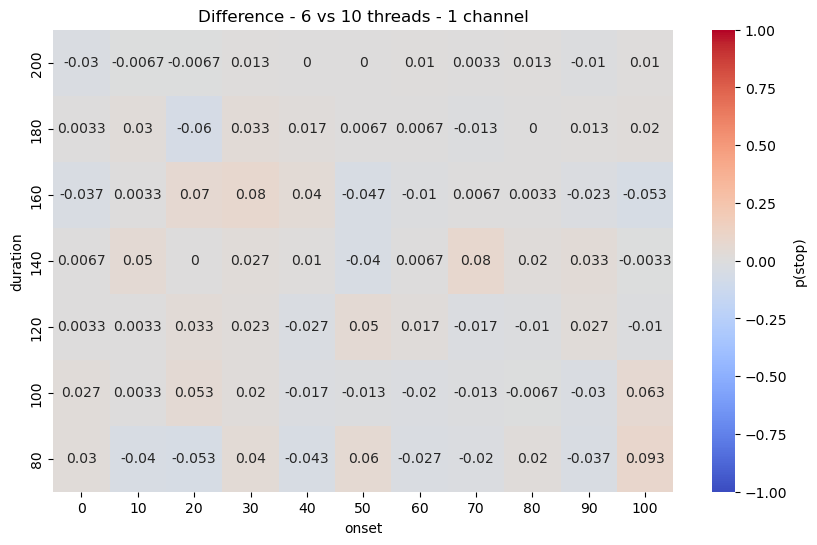

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,1, figsize=(10, 6))
#sns.pointplot(data=datatables_D1, x='GPeA-D1', y='num_stops', errorbar="sd", ax = ax, color='brown')
sns.heatmap(p_stop_reverse_diff, cmap="coolwarm", cbar_kws={'label': 'p(stop)'}, 
           vmin=-1, vmax=1, annot=True)
plt.title('Difference - 6 vs 10 threads - 1 channel')

plt.savefig(figure_dir+'p_stop-heatmap_stop-params-analysis_threads-diff')

### Confidence Interval

In [46]:
p_stop_average = pd.DataFrame(datatables.groupby(['onset', 'duration', 'seed'])['num_stops'].mean()).reset_index()
p_stop_average = p_stop_average.rename({'num_stops': 'p_stop'}, axis=1)
#saveresults_vars(p_stop_average, data_dir+'p_stop_average_iSPN+D2+GPeA')
p_stop_average

,onset,duration,seed,p_stop
0,0,80,0,0.133333
1,0,80,1,0.233333
2,0,80,2,0.166667
3,0,80,3,0.133333
4,0,80,4,0.233333
...,...,...,...,...
765,100,200,5,0.700000
766,100,200,6,0.733333
767,100,200,7,0.800000
768,100,200,8,0.733333


In [63]:
import scipy.stats as st
from sklearn.metrics import r2_score, mean_squared_error

def st_interval(g):
    st_interval = st.t.interval(0.95, len(g) -1, loc=np.mean(g.p_stop), scale=st.sem(g.p_stop))
    return pd.Series( dict({'low': st_interval[0], 'high': st_interval[1]}))


p_stop_t = p_stop_average.groupby(['onset', 'duration']).apply(st_interval).reset_index()

In [66]:
np.where(np.isnan(p_stop_t.low))

(array([27, 34, 41, 47]),)

In [71]:
p_stop_table_low = p_stop_t.pivot_table(index='duration', columns='onset', values='low')
p_stop_reverse_low = p_stop_table_low.iloc[::-1]
p_stop_reverse_low

onset,0,10,20,30,40,50,60,70,80,90,100
duration,,,,,,,,,,,
200,0.540938,0.699398,0.910852,NaN,NaN,NaN,0.983279,0.926820,0.877433,0.706423,0.715373
180,0.370890,0.424223,0.530466,0.765297,0.901540,0.989126,NaN,0.929018,0.869393,0.766715,0.659696
160,0.250728,0.340738,0.401122,0.510950,0.599301,0.701808,0.886400,0.921145,0.870260,0.750546,0.636195
140,0.243859,0.259258,0.263278,0.282955,0.305808,0.424703,0.542683,0.716060,0.798712,0.743406,0.627552
120,0.131369,0.189366,0.220320,0.254263,0.255873,0.321375,0.352196,0.392743,0.518495,0.593704,0.601211
100,0.125144,0.132628,0.194544,0.162241,0.198036,0.181170,0.307698,0.323059,0.315395,0.396918,0.386392
80,0.123315,0.098242,0.105094,0.173805,0.157213,0.191074,0.179546,0.209350,0.264967,0.256033,0.302081


In [68]:
np.where(np.isnan(p_stop_t.high))

(array([27, 34, 41, 47]),)

In [72]:
p_stop_table_high = p_stop_t.pivot_table(index='duration', columns='onset', values='high')
p_stop_reverse_high = p_stop_table_high.iloc[::-1]
p_stop_reverse_high

onset,0,10,20,30,40,50,60,70,80,90,100
duration,,,,,,,,,,,
200,0.639062,0.840602,0.955815,NaN,NaN,NaN,1.003387,0.986513,0.949233,0.846910,0.764627
180,0.509110,0.562443,0.649534,0.841370,0.965127,1.004207,NaN,0.984315,0.950607,0.859952,0.786970
160,0.422605,0.419262,0.532211,0.635717,0.727366,0.818192,0.946933,0.985522,0.929740,0.876121,0.797138
140,0.382808,0.380742,0.390055,0.423712,0.534192,0.535297,0.657317,0.797274,0.894621,0.849927,0.779115
120,0.241964,0.297301,0.313013,0.385737,0.377460,0.438625,0.494470,0.527257,0.628172,0.699630,0.738789
100,0.261523,0.247372,0.332123,0.304426,0.308631,0.358830,0.378968,0.396941,0.464605,0.489748,0.546942
80,0.223352,0.181758,0.208240,0.346195,0.282787,0.322259,0.387120,0.323983,0.355033,0.363967,0.464586


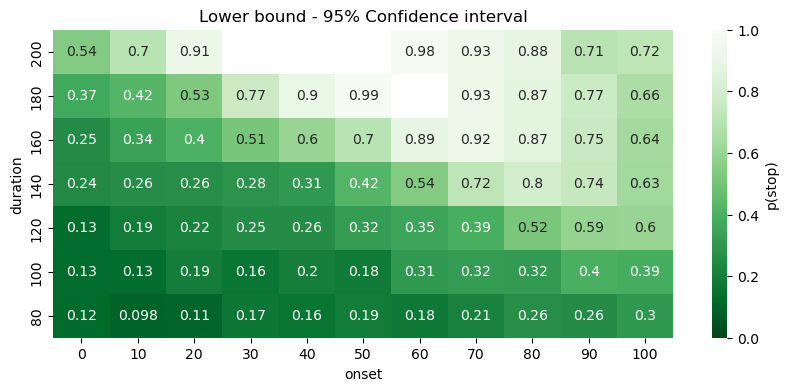

In [81]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,1, figsize=(10, 4))
#sns.pointplot(data=datatables_D1, x='GPeA-D1', y='num_stops', errorbar="sd", ax = ax, color='brown')
sns.heatmap(p_stop_reverse_low, cmap='Greens_r', cbar_kws={'label': 'p(stop)'}, 
           vmin=0, vmax=1, annot=True)
plt.title('Lower bound - 95% Confidence interval')

plt.savefig(figure_dir+'p_stop-heatmap_stop-params-analysis_10threads_t-low')

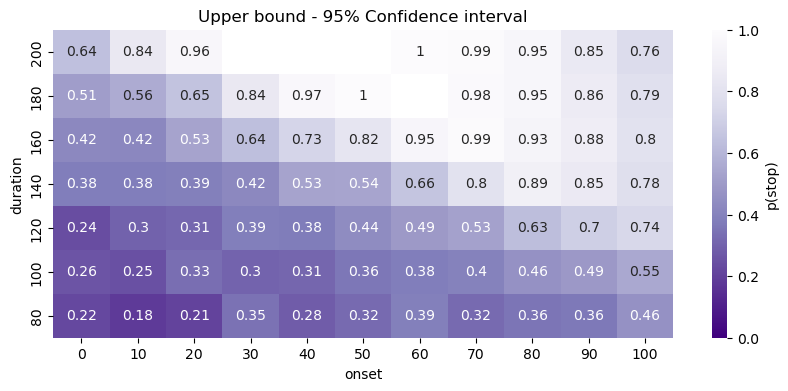

In [82]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,1, figsize=(10, 4))
#sns.pointplot(data=datatables_D1, x='GPeA-D1', y='num_stops', errorbar="sd", ax = ax, color='brown')
sns.heatmap(p_stop_reverse_high, cmap='Purples_r', cbar_kws={'label': 'p(stop)'}, 
           vmin=0, vmax=1, annot=True)
plt.title('Upper bound - 95% Confidence interval')

plt.savefig(figure_dir+'p_stop-heatmap_stop-params-analysis_10threads_t-high')